In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold # for divide data into 10 groups
from random import sample # for reshuffling dataframe

# a wriiten poisson and sigmoid function meets variable size problem so I import two functions only for computation.
from scipy.stats import poisson
from scipy.special import expit

# Problem 2

In [2]:
dt_X = pd.read_csv('hw2-data/Bayes_classifier/X.csv', header=None)
dt_y = pd.read_csv('hw2-data/Bayes_classifier/y.csv', header=None, names=['pred'])

### reshuffle data

In [3]:
data = pd.concat([dt_X, dt_y], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
X = data[data.columns[:-1]]
y = data[data.columns[-1]]

### (a), (b)

In [4]:
def Bayes_classifier(pi, x0, lamb):
    """Makes Bayes classfication using estimation of lambda and pi.
    
    Returns:
        The predicted y0 given an input x0.
    """
    D = len(x0)
    ans = [1-pi, pi]
    for y in range(2):
        arg = [poisson.pmf(x0[d], lamb[y][d]) for d in range(D)]
        ans[y] *= np.prod(arg)
    return np.argmax(ans)

In [5]:
def Bayes_prediction(X, y, fold_number=10):
    """Predicts the classification using Naive Bayes Classifier and returns cross table and lambda hat.
    
    Returns:
        lamb_hat: 10 iterations with a 2*Dimension lambda estimation.
        cross_tab_all: predict vs actual running 10 times.
    """
    D = X.shape[1]
    fold = KFold(n_splits=fold_number)
    cross_tab_all = []
    lamb_hat_all = []
    
    for train_index, test_index in fold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        length = X_train.shape[0]
        pi_hat = y_train.mean()
        lamb_hat = np.zeros((2, D))
        
        for flag in range(2):
            for d in range(D):
                lamb_hat[flag][d] = (sum(X_train.iloc[i][d] * (y_train.iloc[i]==flag) for i in range(length))) / (sum(y_train.iloc[i]==flag for i in range(length)))

        y_pred = np.zeros(len(X_test))
        for i in range(len(X_test)):
            y_pred[i] = Bayes_classifier(pi_hat, X_test.iloc[i], lamb_hat)
          
        cross_tab = np.zeros((2, 2))
        for m in [0, 1]:
            for n in [0, 1]:
                cross_tab[m][n] = sum([(y_test.values[i]==m) & (y_pred[i]==n) for i in range(len(y_pred))])  
        
        cross_tab_all.append(cross_tab)
        lamb_hat_all.append(lamb_hat)
        
    cross_tab_all = sum(cross_tab_all)
    lamb_hat_all

    return lamb_hat_all, cross_tab_all

In [6]:
lamb_hat, cross_tab = Bayes_prediction(X, y)

In [7]:
lamb_hat_mean = np.array(lamb_hat).mean(axis=0)
accu = (cross_tab[0][0] + cross_tab[1][1]) / cross_tab.sum()
print("Accuracy of Naive Bayes Classifier is %.3f" % accu)

Accuracy of Naive Bayes Classifier is 0.870


In [8]:
def plot_stem(lamb):
    """Plots the stem graph using lambda.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10, 10), dpi=300)
    
    ax1.grid()    
    ax1.stem(lamb[0], linefmt='b--', basefmt=None)
    ax1.set_title('lambda with y=0')
    
    ax2.grid()    
    ax2.stem(lamb[1], linefmt='b--', basefmt=None)
    ax2.set_title('lambda with y=1')
    
    plt.xlabel('54 dimensions')    
    plt.ylabel('lambda hat')    

    plt.savefig('lambda hat.png')

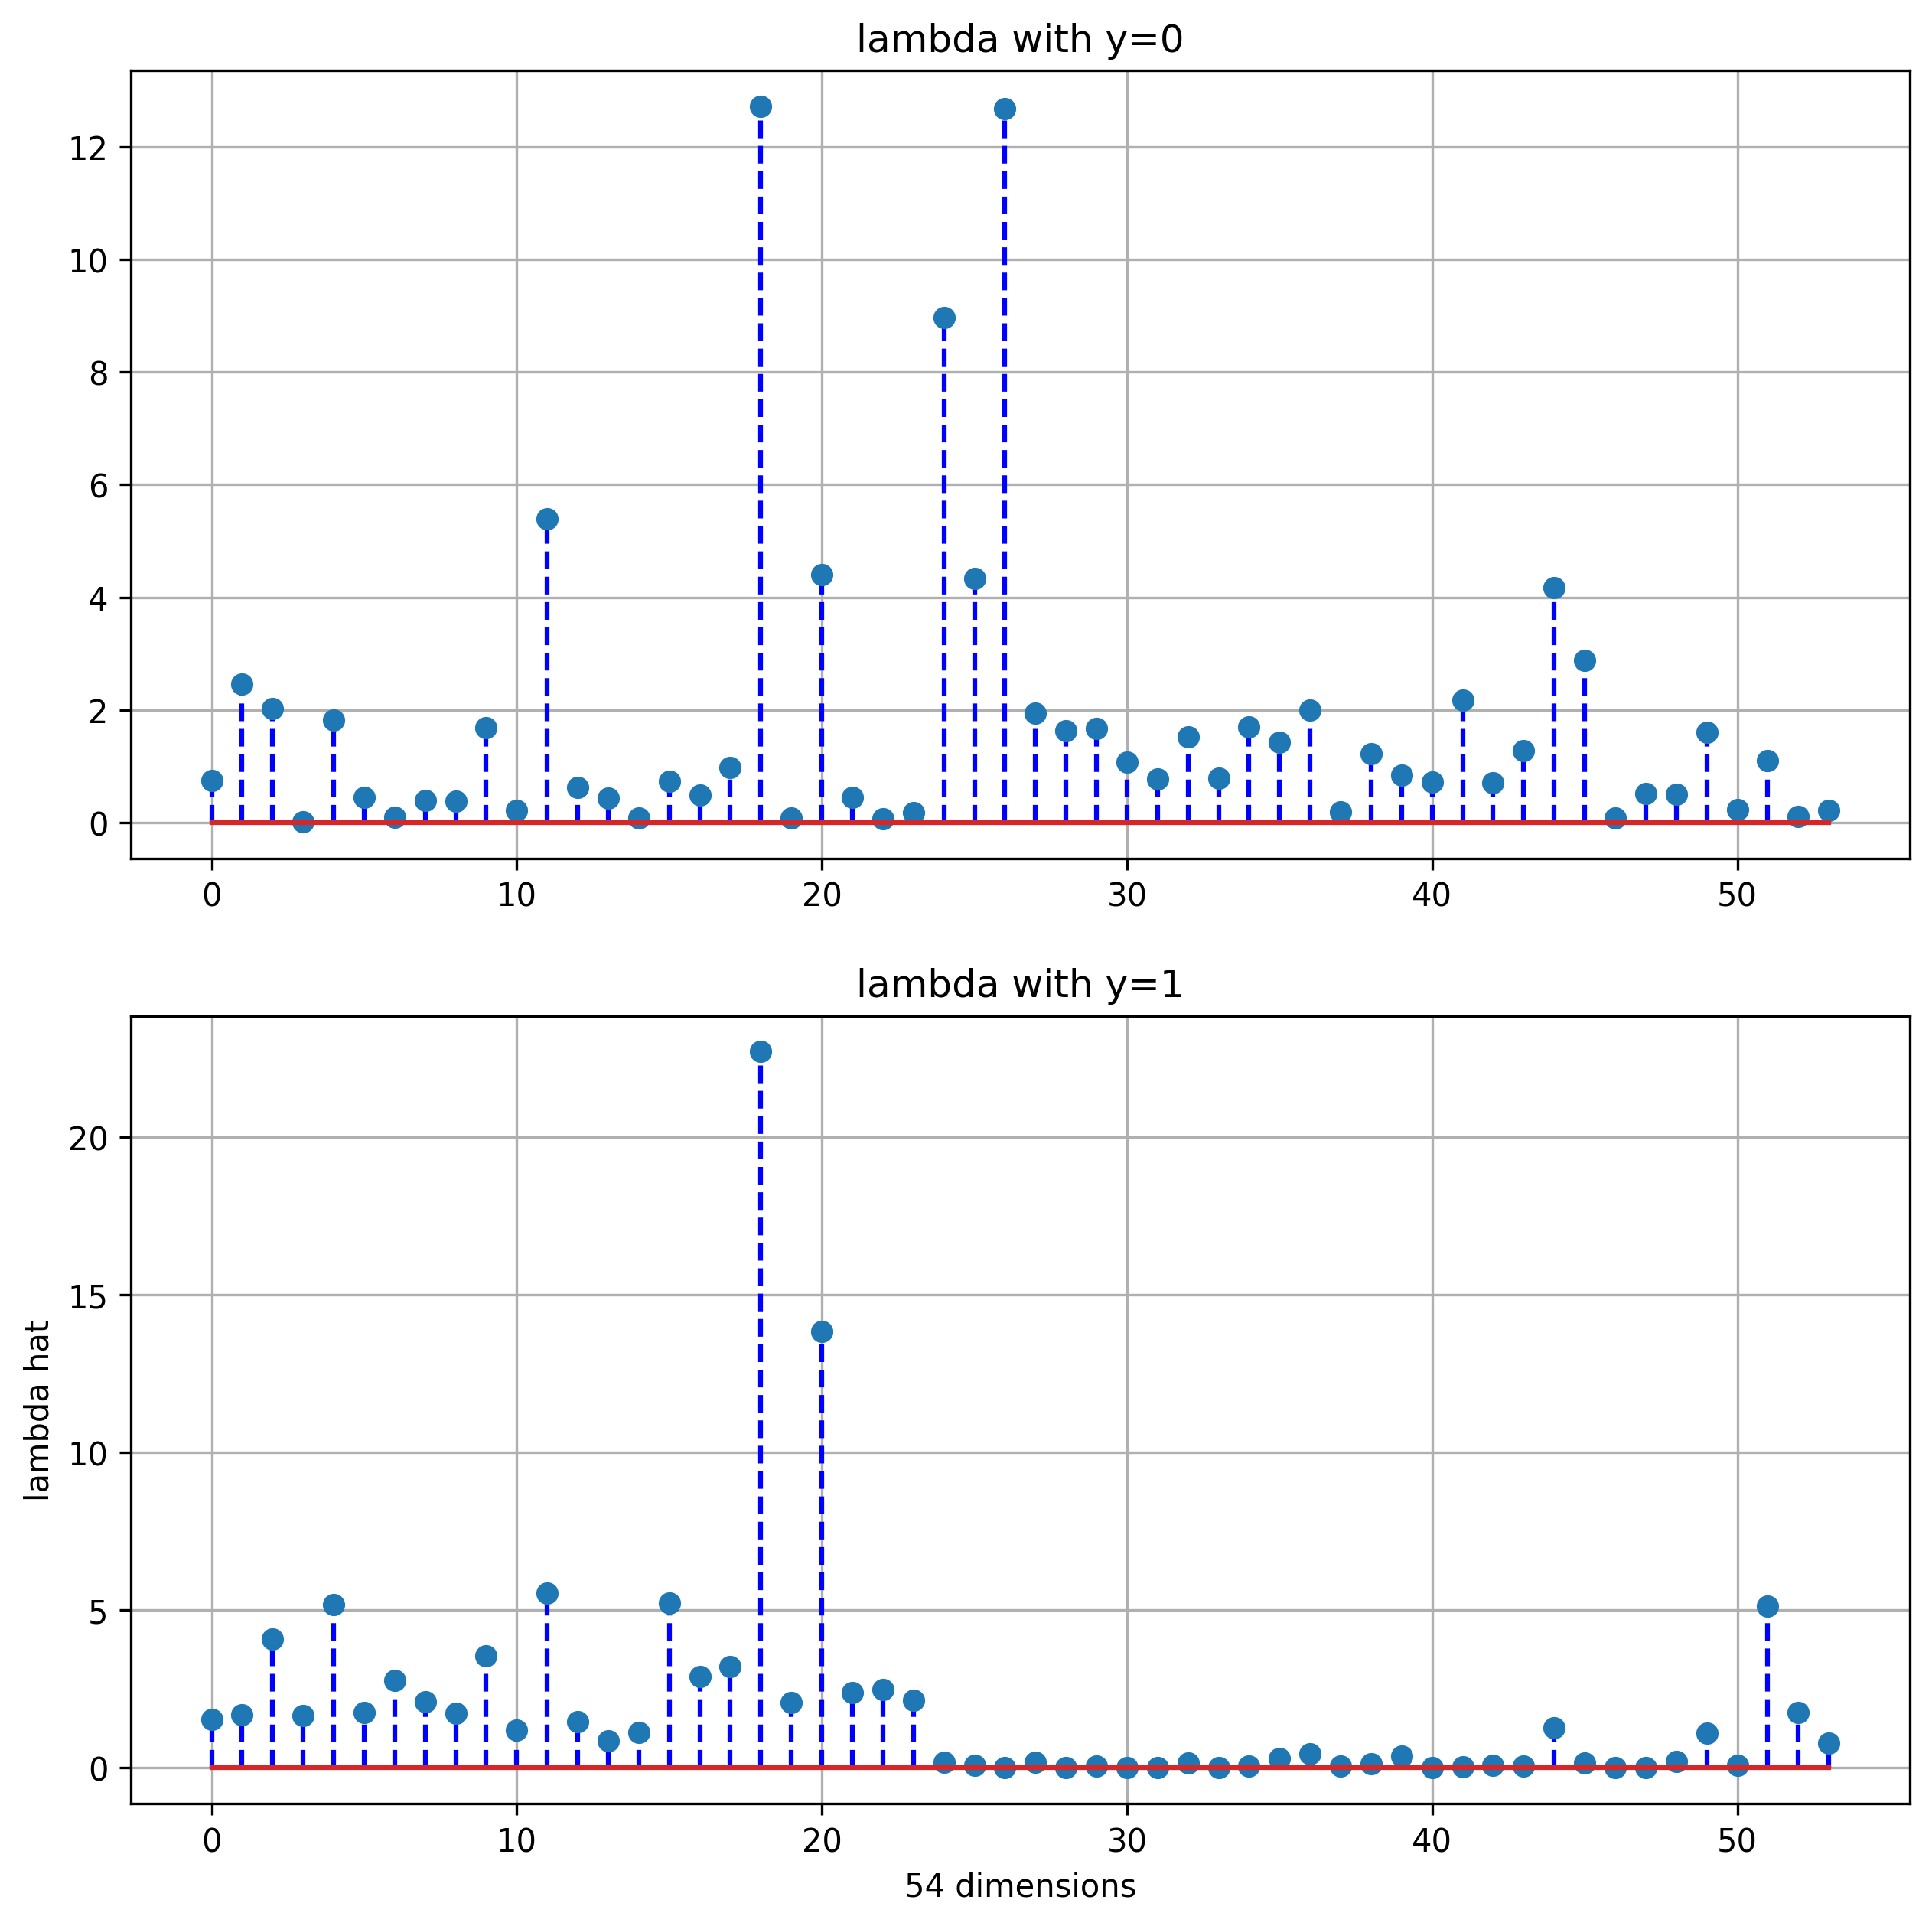

In [9]:
plot_stem(lamb_hat_mean)

### (c)

In [10]:
def logistic_regression(X, y, fold_number=10, iteration=1000):
    """Implements logistic regression for 10 groups of data.
    
    Attributes:
        X, y: reshuffled data.
        fold_number: breaks up into x groups.
        iteration: times of iteration
    
    Returns:
        w_list: 10 groups of w. (54-dimension vector)
        loss_function_list: 10 groups of loss functions against 1000 iterations.
    """
    
    # add additional dimension and set y=-1 if y==0
    X['x0'] = 1
    y[y==0] = -1
    
    # data preparation
    D = X.shape[1]
    fold = KFold(n_splits=fold_number)
    eta = 0.01 / 4600
    
    # record 10 output
    loss_function_list = []
    w_list = []
    
    for train_index, test_index in fold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        length = X_train.shape[0]
        w = np.zeros(D)  # initialize w
        loss_function = []
        for ite in range(iteration+1):  
            gradient = sum((1-expit(y_train.values[i]*X_train.values[i].dot(w)))*y_train.values[i]*X_train.values[i] for i in range(length))
            loss_function.append(sum(np.log(expit(y_train.values[i]*X_train.values[i].dot(w))) for i in range(length)))
            w += eta * gradient
        w_list.append(w)
        loss_function_list.append(loss_function)
    
    return w_list, loss_function_list

In [11]:
w_list, loss_function_list = logistic_regression(X, y)

In [12]:
def plot_loss_func(loss_func_list, method):
    fig = plt.figure(figsize=(12, 8), dpi=300)
    plt.grid()
    for i in range(10):
        plt.plot(loss_func_list[i])
    plt.xlabel('iteration')
    plt.ylabel('Loss function')
    plt.title('Loss function of 10 times')
    plt.savefig('Loss function %s.png' % method)

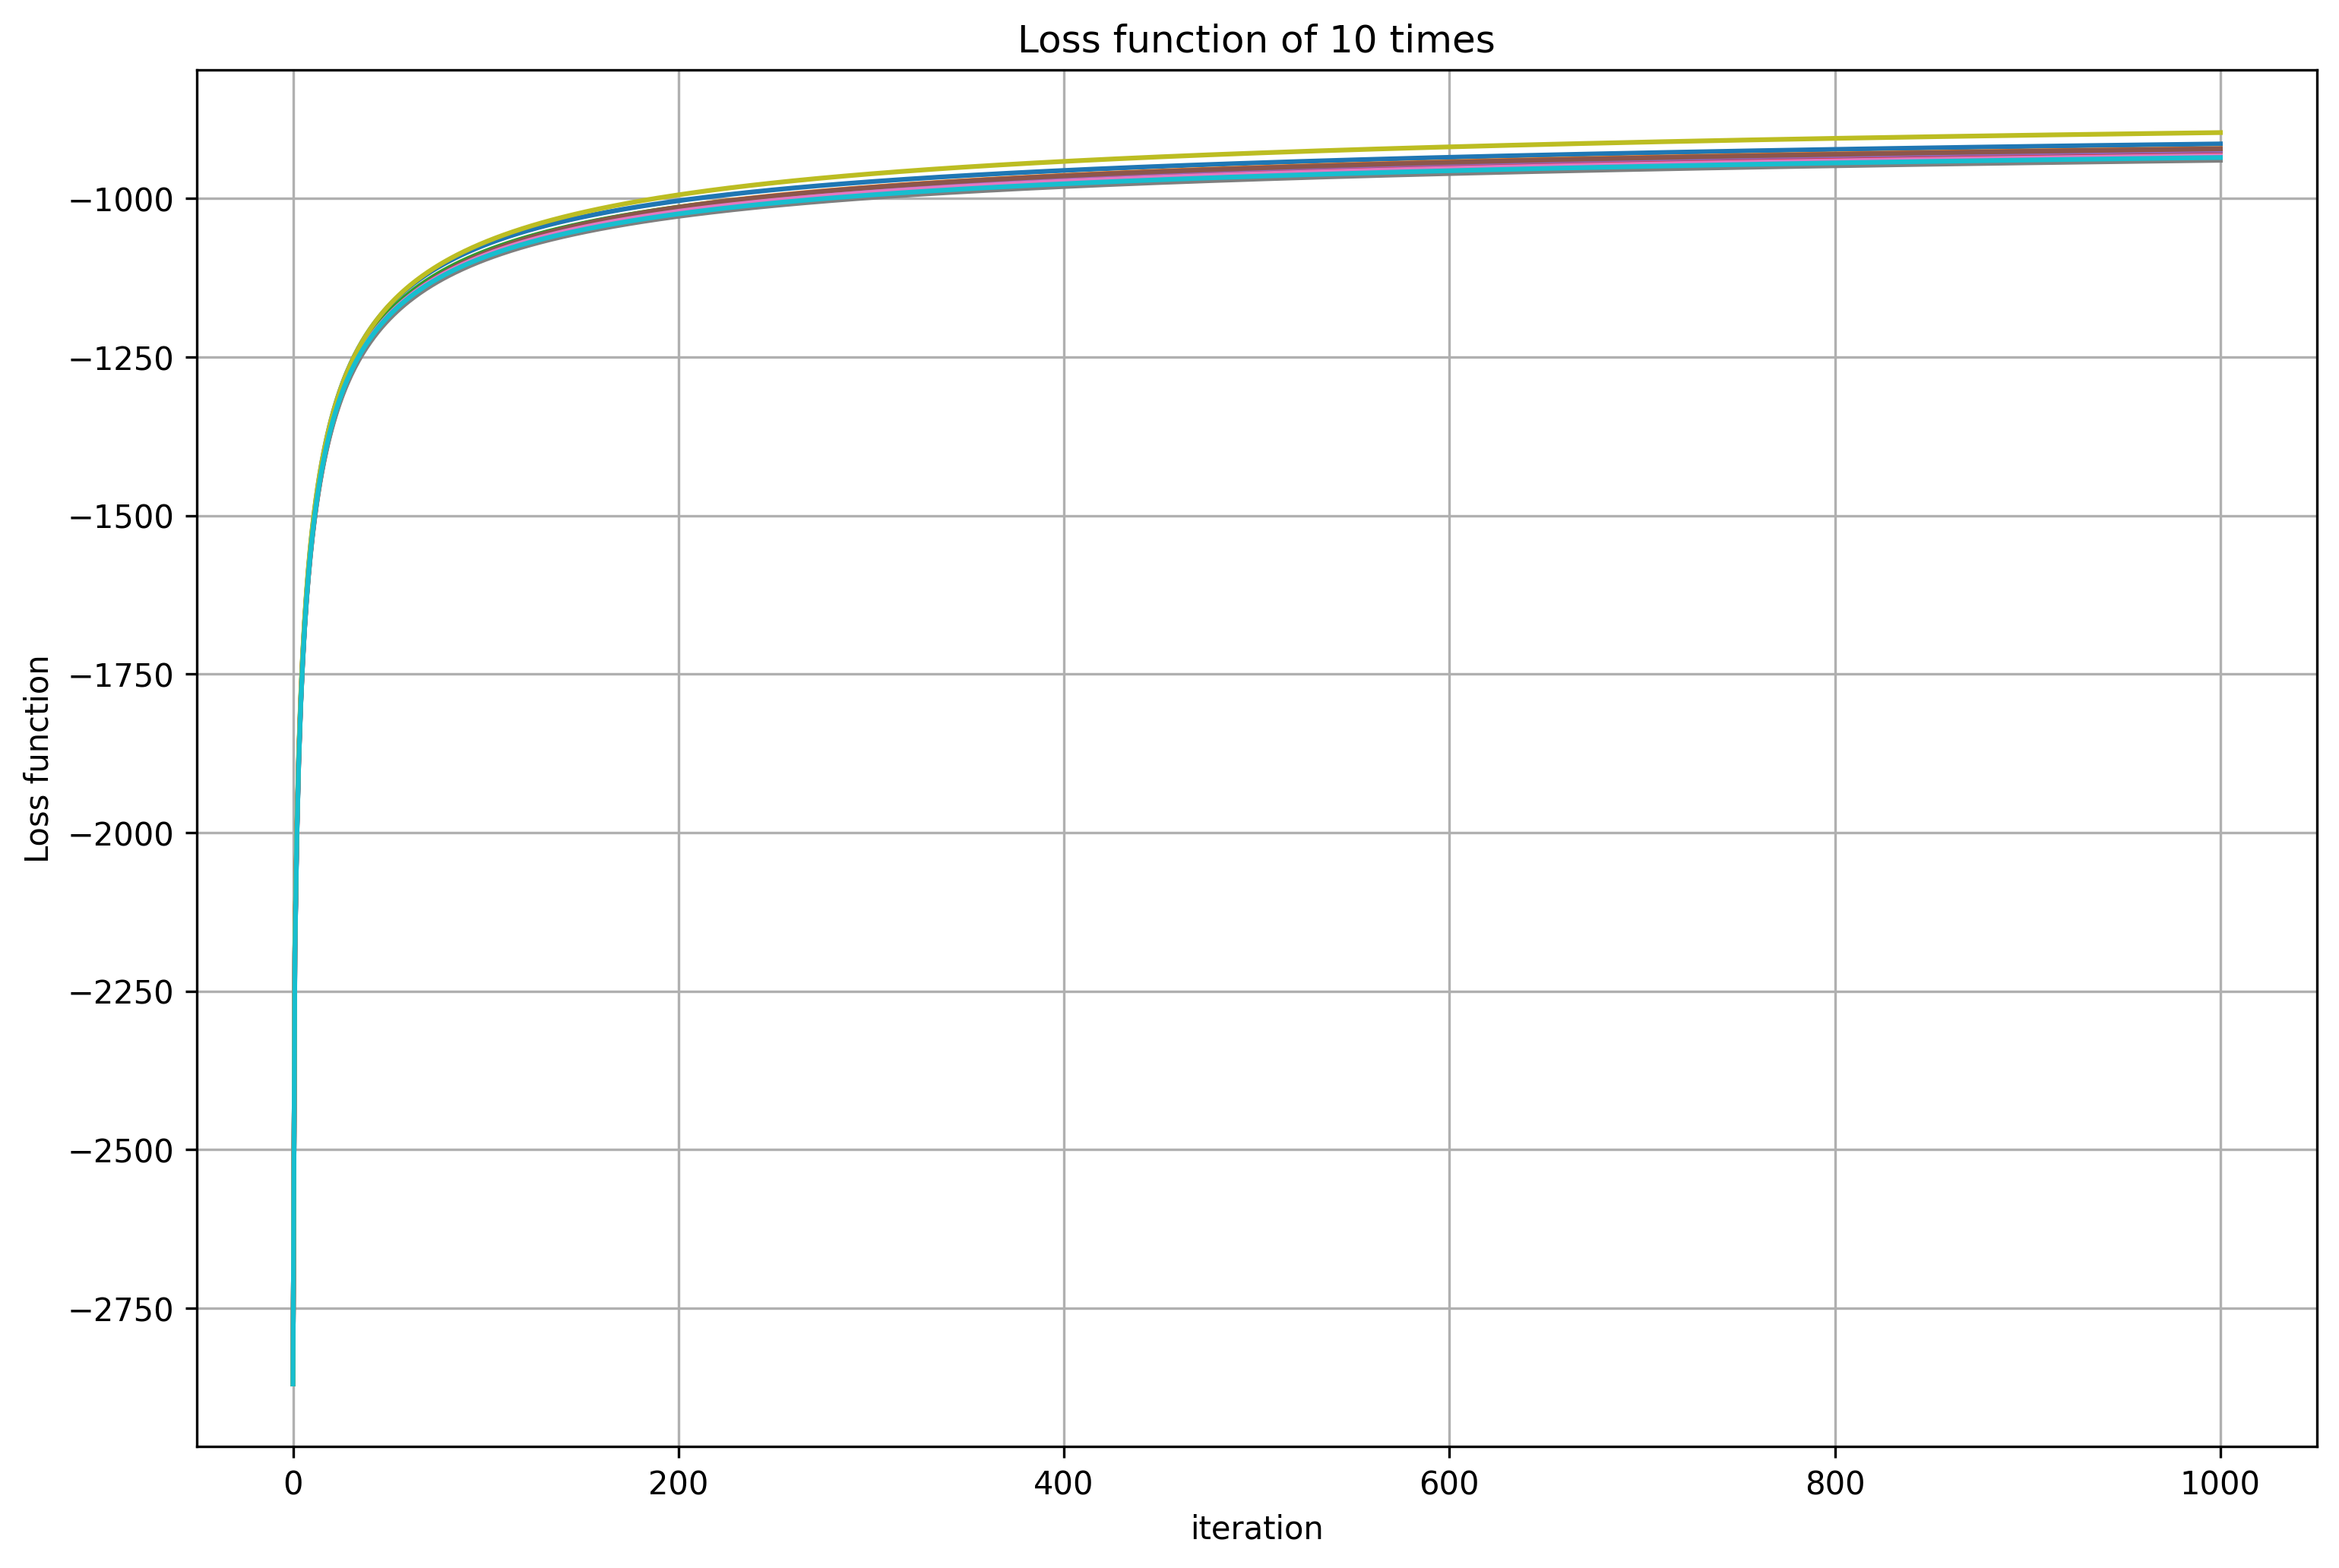

In [13]:
plot_loss_func(loss_function_list, 'logistic regression')

### (d)

In [14]:
def newton_method(X, y, fold_number=10, iteration=100):
    """Implements logistic regression for 10 groups of data.
    
    Attributes:
        X, y: reshuffled data.
        fold_number: breaks up into x groups.
        iteration: times of iteration
    
    Returns:
        w_list: 10 groups of w. (54-dimension vector)
        loss_function_list: 10 groups of loss functions against 100 iterations.
    """
    
    # add additional dimension and set y=-1 if y==0
    X['x0'] = 1
    y[y==0] = -1
    
    # data preparation
    D = X.shape[1]
    fold = KFold(n_splits=fold_number)
    loss_function_list = []
    w_list = []
    cross_tab_all = []
    
    for train_index, test_index in fold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        length = X_train.shape[0]
        w = np.zeros(D)  # initialize w
        loss_function = []
        for ite in range(iteration+1):
            gradient = sum((1-expit(y_train.values[i]*X_train.values[i].dot(w)))*y_train.values[i]*X_train.values[i] for i in range(length))
            gradient_2nd = -sum(float((expit(y_train.values[i]*X_train.values[i].dot(w))*(1-expit(y_train.values[i]*X_train.values[i].dot(w)))))*np.multiply(X_train.values[i], X_train.values[i].reshape(-1, 1)) for i in range(length))
            inv = np.linalg.inv(gradient_2nd + np.diag(([1e-6] * D)))
            loss_function.append(sum(np.log(expit(y_train.values[i]*X_train.values[i].dot(w))) for i in range(length)))
            w -= np.dot(inv, gradient)
        w_list.append(w)
        loss_function_list.append(loss_function)
        
        # predict y
        y_pred = expit(X_test.values.dot(w))
        y_pred[y_pred < 0.5] = -1
        y_pred[y_pred >= 0.5] = 1

        cross_tab = []
        for m in [-1, 1]:
            for n in [-1, 1]:
                cross_tab.append(sum([(y_test.values[i]==m) & (y_pred[i]==n) for i in range(len(y_pred))]))
        cross_tab_all.append(cross_tab)
    
    cross_tab_all = np.array(cross_tab_all).reshape(2, 2)
    
    return w_list, loss_function_list, cross_tab_all

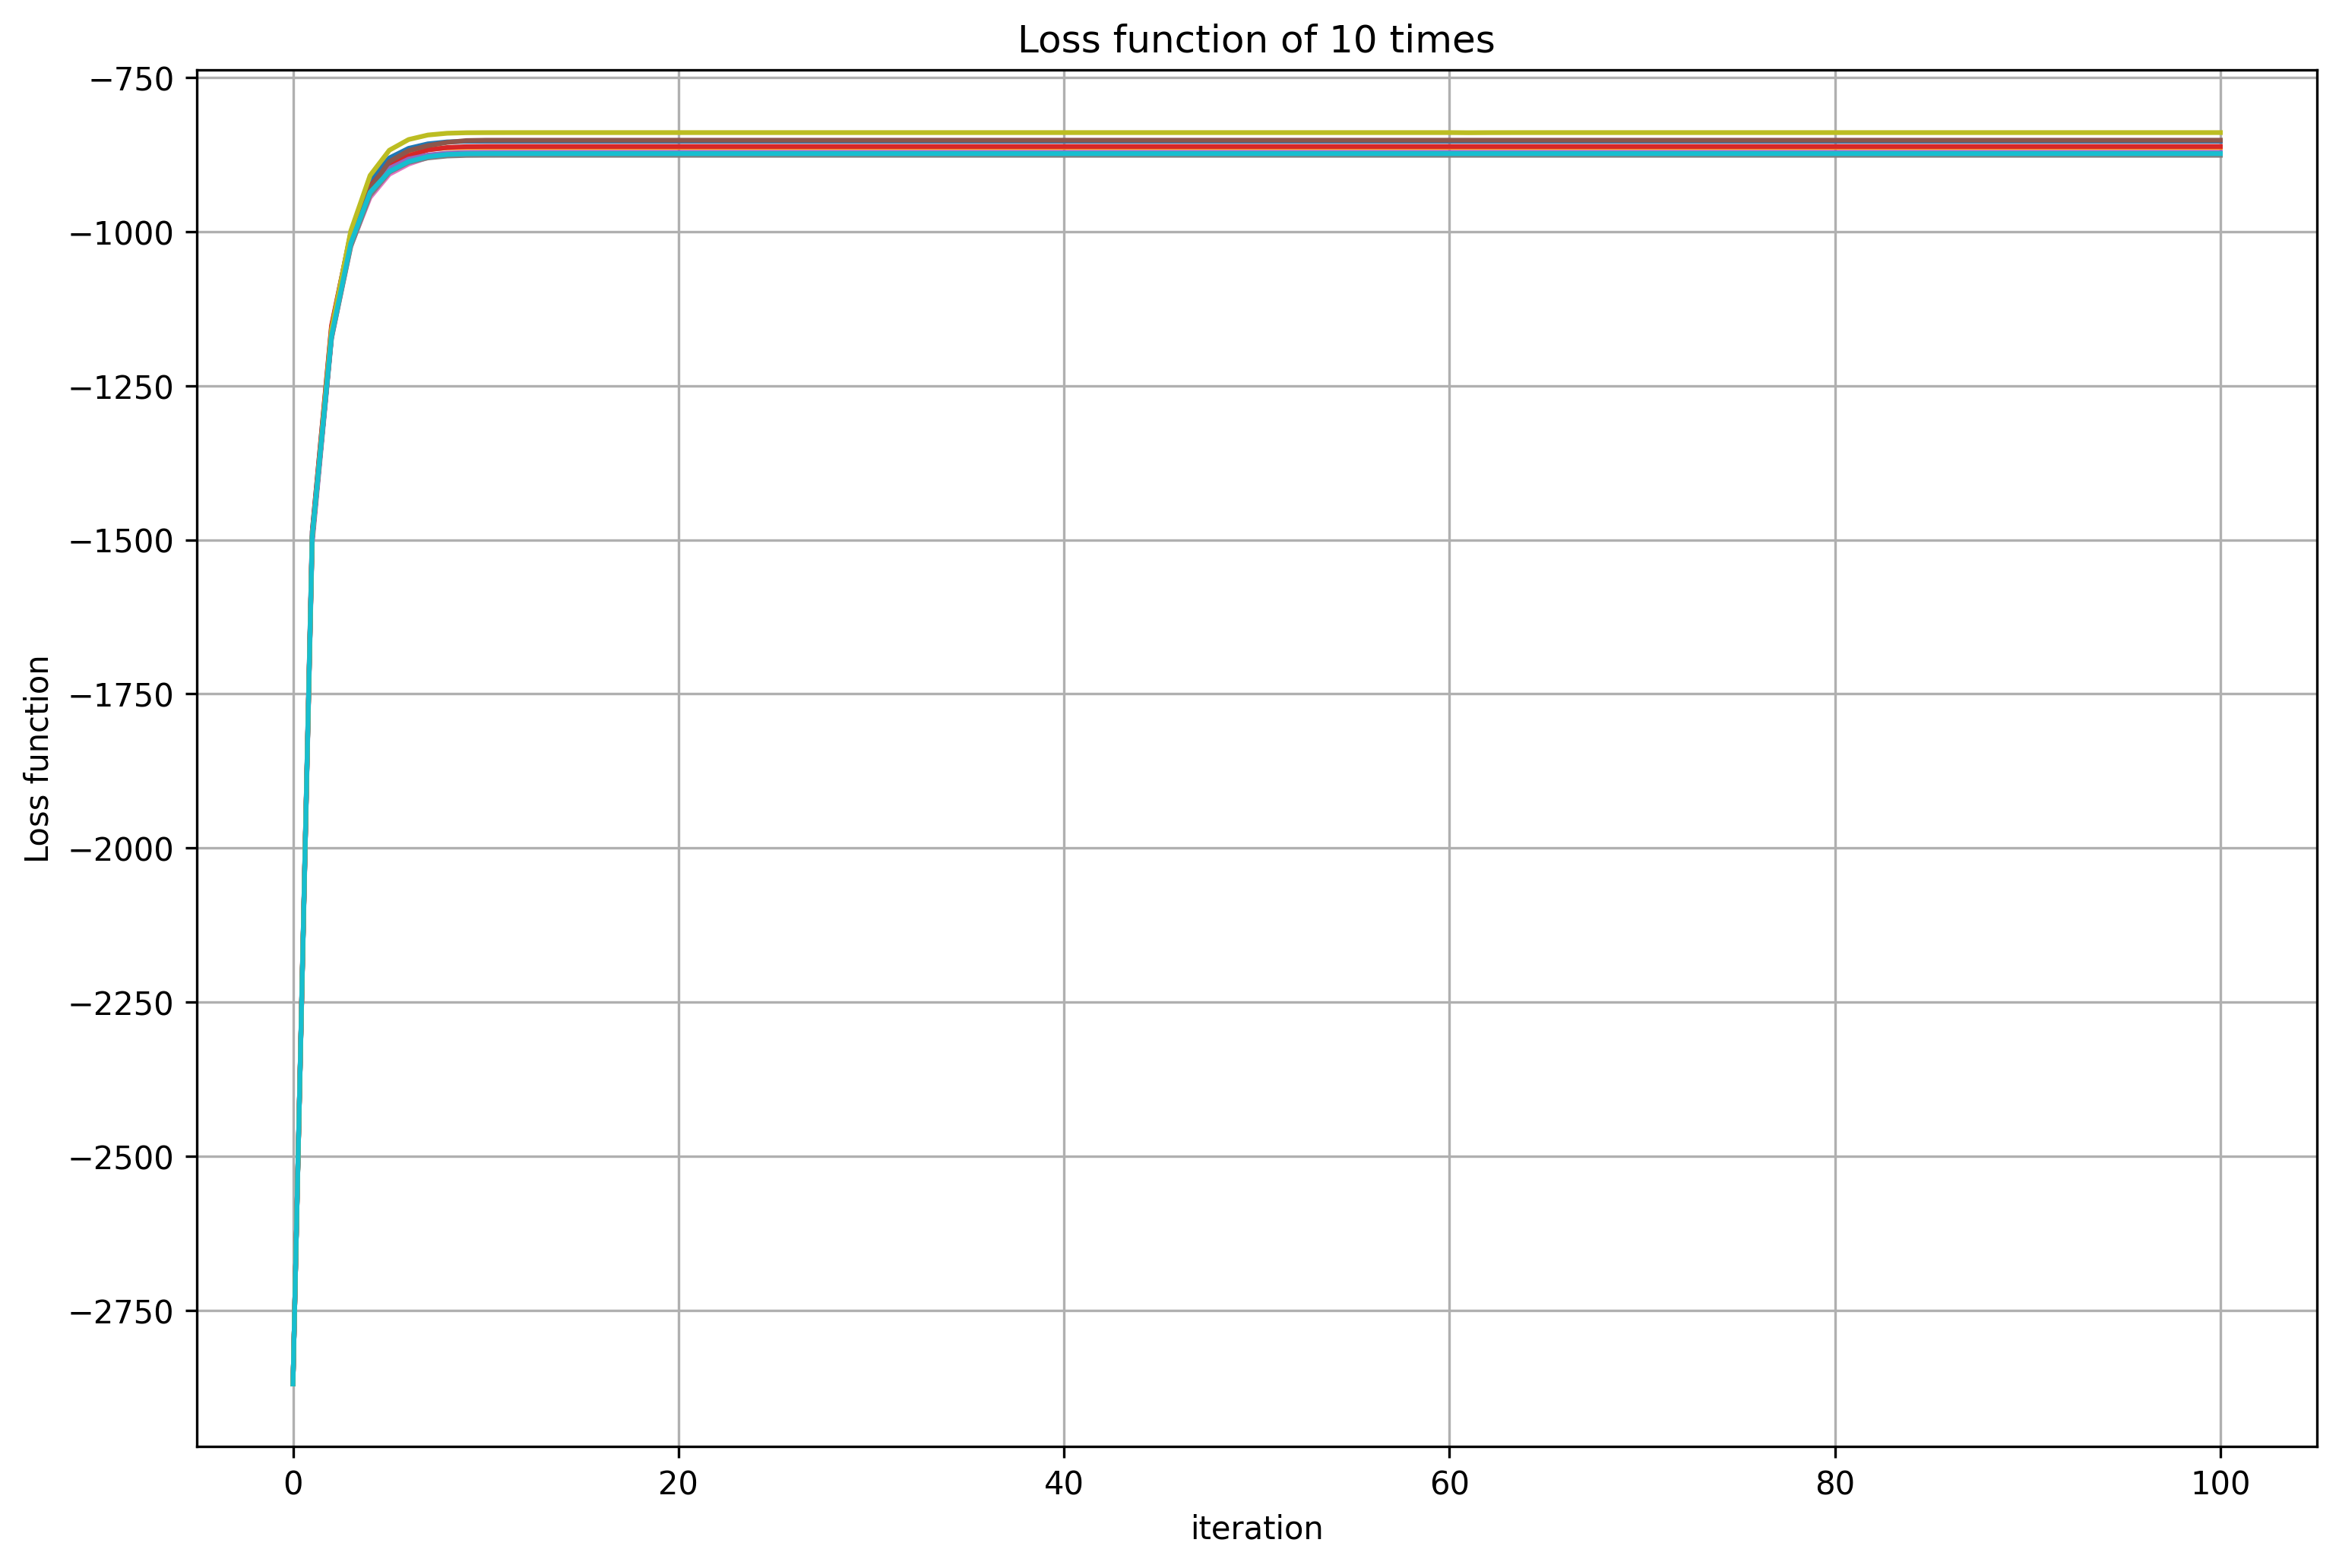

In [15]:
w_list, loss_function_list, cross_table = newton_method(X, y)
plot_loss_func(loss_function_list, 'newton')

In [22]:
cal = cross_table.sum(axis=0)
accu = (cal[0][0] + cal[1][1]) / cal.sum()
print("Accuracy of Newton's method is %.3f" % accu)

Accuracy of Newton's method is 0.923


# Problem 3

In [23]:
data_dir = 'hw2-data/Gaussian_process/'
X_train = pd.read_csv(data_dir + 'X_train.csv', header=None)
X_test = pd.read_csv(data_dir + 'X_test.csv', header=None)
y_train = pd.read_csv(data_dir + 'y_train.csv', header=None, names=['y'])
y_test = pd.read_csv(data_dir + 'y_test.csv', header=None, names=['y'])

In [24]:
def kernel(x_i, x_j, b):
    return np.exp(-sum((x_i - x_j)**2) / b)

In [25]:
def cal_gaussian_process(b, sigma2, X_train, y_train, X_test):
    """Calculates predicted values given training and testing data.
    
    Attributes:
        b, sigma2: hyperparameters.
        X_train, y_train: training data.
        X_test: testing data.
    
    Returns:
        miu, Sigma: new distribution parameters.
    """
    n = X_train.shape[0]
    p = X_test.shape[0]

    K_n = np.array([[kernel(X_train[i], X_train[j], b) for i in range(n)] for j in range(n)])
    inv = np.linalg.inv(np.diag([sigma2] * n) + K_n)
    miu = np.zeros(p)
    Sigma = np.zeros(p)
    
    for j in range(p):  # for every new point x0 in testing data.
        x0 = X_test[j]
        K_Dn = np.zeros(n)  # initialize K_Dn 
        for i in range(n):
            K_Dn[i] = kernel(X_train[i], x0, b)  # calculate every item in K_Dn
        
        miu[j] = K_Dn.dot(inv).dot(y_train)[0]  # calculate new distribution parameters
        Sigma[j] = sigma2 + kernel(x0, x0, b) - K_Dn.dot(inv).dot(K_Dn.T)
        
    return miu, Sigma

### (a)

In [26]:
RMSE = []
for b in [5, 7, 9, 11, 13, 15]:
    for sigma2 in np.arange(0.1, 1.1, .1):
        miu, Sigma = cal_gaussian_process(b, sigma2, X_train.values, y_train.values, X_test.values)
        RMSE.append(np.sqrt(sum((y_test.values.T[0] - miu) ** 2) / X_test.values.shape[0]))

In [27]:
RMSE = np.array(RMSE).reshape(6, 10)

In [28]:
print(RMSE)

[[1.9662761  1.93313534 1.9234202  1.9221976  1.92476912 1.92921255
  1.93463407 1.9405831  1.94681994 1.9532125 ]
 [1.92016326 1.90487652 1.90808033 1.91590168 1.92480408 1.9337014
  1.94225377 1.95038004 1.95809307 1.96543804]
 [1.89764875 1.90251913 1.91764769 1.93251433 1.94569947 1.95723479
  1.96740326 1.97649175 1.98474077 1.99234121]
 [1.89050711 1.91498101 1.93884878 1.95793625 1.97321582 1.98576421
  1.99637514 2.00560322 2.01383544 2.0213448 ]
 [1.8958485  1.9355859  1.96459732 1.98550199 2.00131427 2.01387845
  2.02431038 2.03330678 2.04131749 2.04864155]
 [1.90960322 1.95954883 1.99080359 2.01191545 2.02737028 2.03946517
  2.04946338 2.05810489 2.06584527 2.07297606]]


In [30]:
pd.DataFrame(RMSE, index=[5, 7, 9, 11, 13, 15], columns=np.arange(0.1, 1.1, .1)).to_excel('RMSE.xlsx')

### (b)

In [31]:
X_train4 = X_train[3].values.reshape(-1, 1)  # choose the 4th dimension

In [32]:
b = 5
sigma2 = 2.0
_miu, _Sigma = cal_gaussian_process(b, sigma2, X_train4, y_train.values, X_train4)

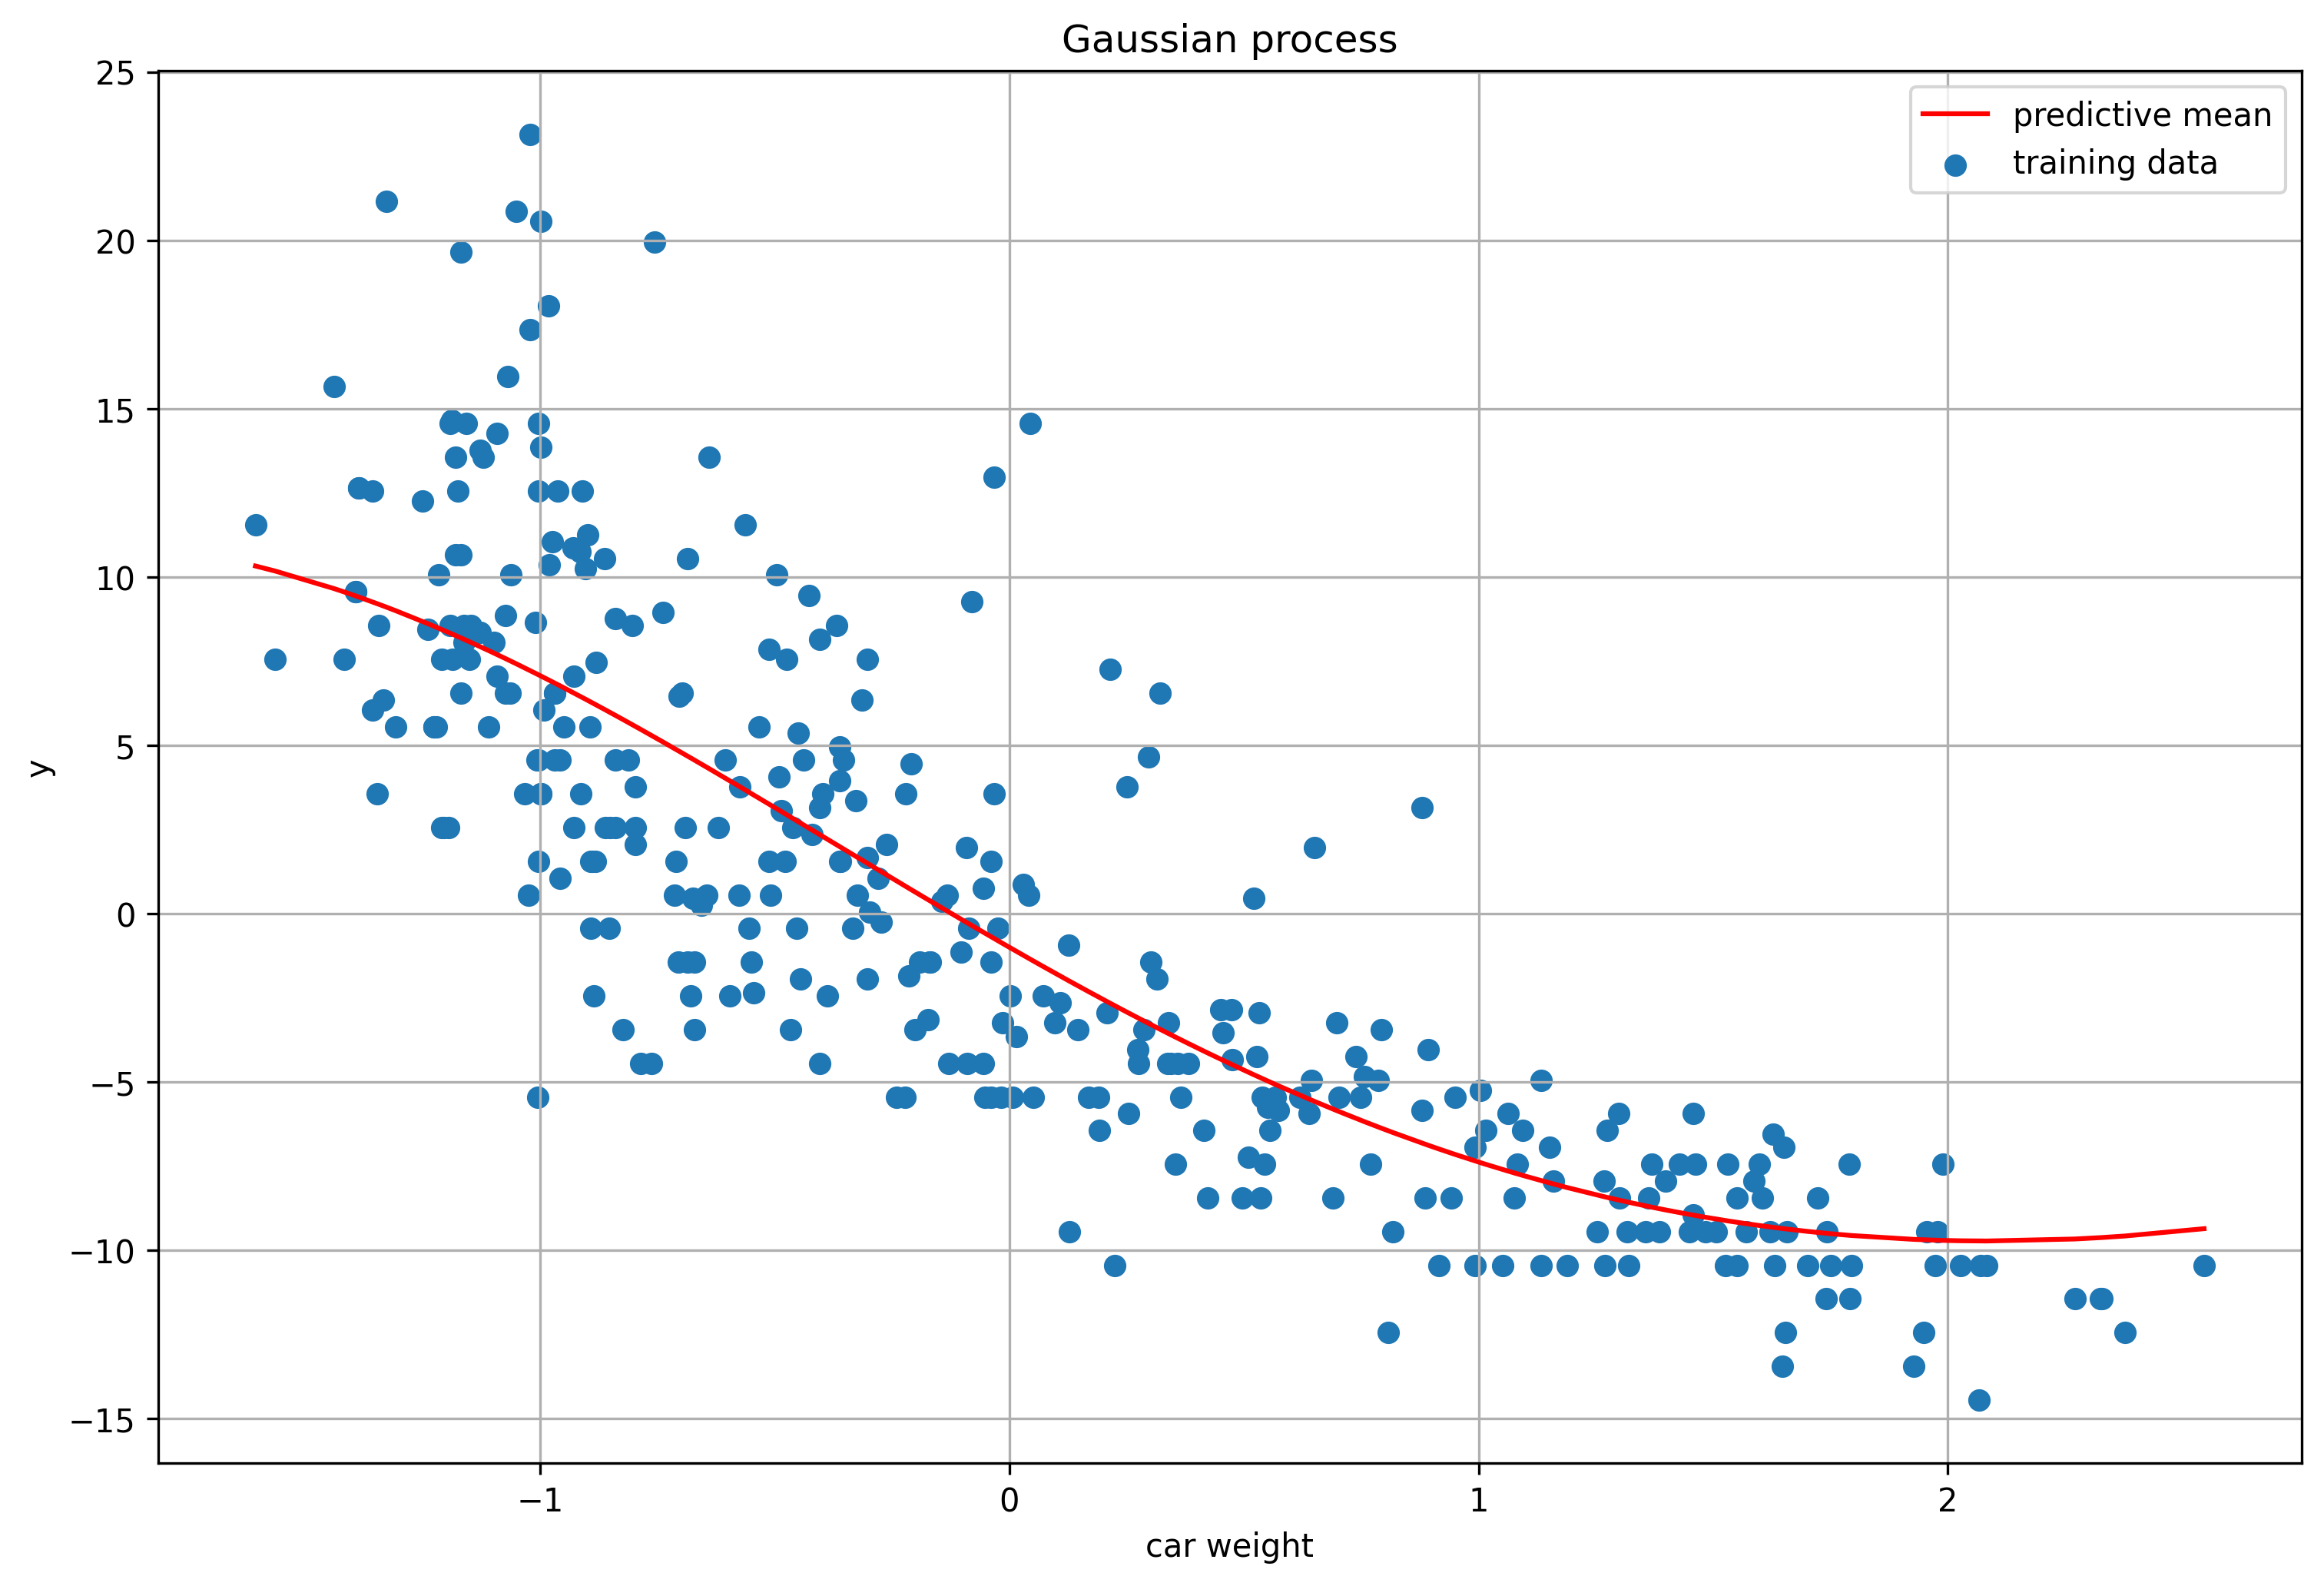

In [33]:
fig = plt.figure(figsize=(12, 8), dpi=300)
plt.grid()
plt.scatter(X_train4, y_train, label='training data')
b = np.array([X_train4[:, 0], _miu]).T
c = b[b[:, 0].argsort()].T
plt.plot(c[0], c[1], color='red', label='predictive mean')
plt.xlabel('car weight')
plt.ylabel('y')
plt.title('Gaussian process')
plt.legend()
plt.savefig('Gaussian process comparison.png')